In [1]:
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from typing import List, Tuple
from collections import Counter
from scipy.stats import entropy as shannon_entropy
from collections import Counter
from itertools import chain
import time

In [2]:
# Constants
PARTY_SIZE = 4
SAMPLE_SIZE = 1000

In [ ]:
# 1. Load data
def prepare_data(qrng_path: str, threat_path) -> Tuple[np.ndarray, np.ndarray]:
    qrng = pd.read_csv(qrng_path).values
    threat = pd.read_csv(threat_path).values.astype(int)
    assert qrng.shape == threat.shape == (SAMPLE_SIZE, PARTY_SIZE)
    return qrng, threat

In [ ]:
def majority_classical(bits: List[int]) -> int:
    """Return 1 if majority of bits are 1 (3 or more in a 4-party setup)."""
    return int(sum(bits) >= 3)

In [ ]:
def or_classical(bits: List[int]) -> int:
    """Return 1 if at least one party saw the threat."""
    return int(any(bits))

In [ ]:
def compute_metrics(
    predictions: List[int],
    true_bits: np.ndarray,
    angles: np.ndarray
) -> Tuple[float, float, float]:
    """
    Evaluate predictions against classical ground truths.
    
    Returns:
        - Accuracy vs majority
        - Accuracy vs OR
        - QRNG angle entropy (Shannon entropy over 32 bins)
    """
    assert len(predictions) == len(true_bits) == len(angles)

    correct_majority = 0

    for i in range(len(predictions)):
        pred = predictions[i]
        majority_truth = majority_classical(true_bits[i])

        if pred == majority_truth:
            correct_majority += 1


    acc_majority = correct_majority / len(predictions)

    # Entropy over flattened angles
    flat_angles = angles.flatten()
    hist, _ = np.histogram(flat_angles, bins=32, range=(0, 2 * np.pi), density=True)
    entropy_val = shannon_entropy(hist)

    return acc_majority, entropy_val

In [ ]:
# 2. Build correct Q-SMPC circuit
def build_qsmpc_circuit(angles: List[float], bits: List[int]) -> QuantumCircuit:
    qc = QuantumCircuit(PARTY_SIZE, PARTY_SIZE)
    
    # Step 1: Graph state
    qc.h(range(PARTY_SIZE))
    for i in range(PARTY_SIZE - 1):
        qc.cz(i, i + 1)

    # Step 2: Apply Rz(θ + π·x)
    for i in range(PARTY_SIZE):
        theta = angles[i] + (np.pi if bits[i] == 1 else 0)
        qc.rz(theta, i)

    # Step 3: All measure in X-basis (via Hadamard)
    for i in range(PARTY_SIZE):
        qc.h(i)
        qc.measure(i, i)

    return qc

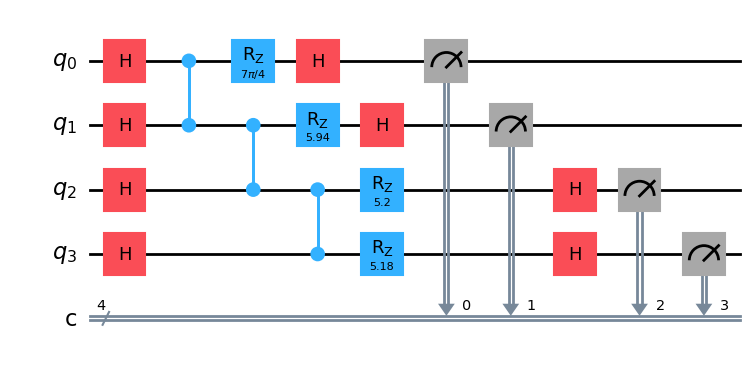

In [8]:
angles_data, bits_data = prepare_data('./data/qrng_angles.csv', './data/threat_bits.csv')
backend = AerSimulator()

qc = build_qsmpc_circuit(angles_data[0], bits_data[0])
qc.draw('mpl')

In [9]:
def simulate_round(angles: List[float], bits: List[int], backend, shots: int = 16) -> List[str]:
    qc = build_qsmpc_circuit(angles, bits)
    compiled = transpile(qc, backend)
    result = backend.run(compiled, shots=shots).result()

    counts = result.get_counts()
    return list(chain.from_iterable([k] * v for k, v in counts.items()))


In [ ]:
def majority_vote_bitstring(bitstrings: List[str]) -> str:
    """Compute majority bitstring over multiple shots."""
    length = len(bitstrings[0])
    result = ''

    for i in range(length):
        bits_at_i = [b[i] for b in bitstrings]
        most_common = Counter(bits_at_i).most_common(1)[0][0]
        result += most_common

    return result


In [11]:
def xor_bitstring(bitstring: str) -> int:
    """XOR all bits in a bitstring."""
    return int(np.bitwise_xor.reduce([int(b) for b in bitstring]))

In [12]:
def run_all_samples(
    angles_data: np.ndarray,
    bits_data: np.ndarray,
    backend,
    shots_per_round: int = 16,
    verbose: bool = False
) -> List[int]:
    """
    Run the Q-SMPC simulation over all samples.
    
    Returns a list of final XOR output bits (0 or 1) for each sample.
    """
    predictions = []
    latencies = []

    for i in range(SAMPLE_SIZE):
        angles = angles_data[i]
        bits = bits_data[i]

        start = time.perf_counter()
        # Run and aggregate
        bitstrings = simulate_round(angles, bits, backend, shots=shots_per_round)

        majority = majority_vote_bitstring(bitstrings)

        output_bit = majority_classical([int(b) for b in majority])

        end = time.perf_counter()
        latency_ms = (end - start) * 1000
        latencies.append(latency_ms)

        predictions.append(output_bit)

        if verbose and (i < 5 or i % 100 == 0):
            print(f"[{i+1}/{SAMPLE_SIZE}] bits={bits.tolist()}, output={output_bit}, majority={majority}")
        
    return predictions, latencies


In [13]:
# Load data
angles_data, bits_data = prepare_data('./data/qrng_angles.csv', './data/threat_bits.csv')
backend = AerSimulator()

predictions, latencies = run_all_samples(angles_data, bits_data, backend, shots_per_round=16, verbose=True)

# Metrics
acc_maj, entropy_val = compute_metrics(predictions, bits_data, angles_data)
mean_latency = np.mean(latencies)
throughput = SAMPLE_SIZE / (sum(latencies) / 1000)

print(f"Final Evaluation")
print(f"Correctness vs Majority: {acc_maj:.3f}")
print(f"QRNG Entropy:            {entropy_val:.3f} bits")
print(f"Mean Per-Run Latency:     {mean_latency:.1f} ms")
print(f"Aggregate Throughput:     {throughput:.2f} rounds/sec")


[1/1000] bits=[0, 0, 1, 1], output=0, majority=0010
[2/1000] bits=[1, 1, 1, 1], output=0, majority=0110
[3/1000] bits=[0, 1, 0, 1], output=0, majority=1010
[4/1000] bits=[0, 0, 1, 0], output=0, majority=1100
[5/1000] bits=[1, 1, 0, 0], output=0, majority=0010
[101/1000] bits=[0, 1, 0, 0], output=0, majority=1000
[201/1000] bits=[1, 1, 0, 0], output=0, majority=0100
[301/1000] bits=[1, 0, 0, 0], output=0, majority=0001
[401/1000] bits=[1, 1, 0, 1], output=1, majority=1101
[501/1000] bits=[1, 1, 0, 0], output=1, majority=1111
[601/1000] bits=[0, 1, 0, 0], output=0, majority=1100
[701/1000] bits=[1, 0, 1, 1], output=1, majority=0111
[801/1000] bits=[0, 1, 0, 0], output=0, majority=0001
[901/1000] bits=[1, 1, 1, 1], output=0, majority=1001
Final Evaluation
Correctness vs Majority: 0.592
QRNG Entropy:            3.463 bits
Mean Per-Run Latency:     245.4 ms
Aggregate Throughput:     4.07 rounds/sec
